In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import warnings
import pandas as pd
import numpy as np
from tifffile import imread
from nd2reader import ND2Reader

import napari
from napari import Viewer
from magicgui.widgets import Container
from magicgui import magicgui

sys.path.append('../libraries')
import general_functions as gen
import napari_build_viewer as bv_f
import input_functions as inp_f

In [2]:
warnings.filterwarnings('ignore')

## Define experiment

In [3]:
info_file_path = r'D:\BARC\BARC_Wanjuan\210603_B3_5\210603_halo_B3_5_info.txt'

In [5]:
# read the file
info_file = open(info_file_path, 'r')
info_lines = info_file.readlines()
info_file.close()

# read info about the data frame
exp_dir,df_name = inp_f.read_df_info(info_lines)

# read in the data frame
df = pd.read_pickle(os.path.join(exp_dir,'df',df_name))

# get info about the channels
channel_list = inp_f.read_channels(info_lines,check=True,df=df,exp_dir=exp_dir)

# get info about the tags
tag_list = inp_f.read_tags(info_lines,df=df)

# get info about what will be plotted
graph_list = inp_f.read_graphs(info_lines,df,channel_list)

# get info about the general settings
time_threshold,small_im_size,label_contour,gen_track_columns = inp_f.read_settings(info_lines)

# get info about the caluclations 
object_properties = inp_f.read_properties(info_lines)
# consider pushing properties_ring too

## Extract info from the data frame

In [6]:
# sort 
df = df.sort_values(by=['track_id','t'])

Expected execution time < 1min.

In [7]:
%%time

# generate labels layer
labels = gen.labels_from_df(df)

Wall time: 6.33 s


In [29]:
# generate data for the tracking layer
data,properties,graph = gen.trackData_from_df(df,col_list = gen_track_columns)

In [9]:
# create data for tagging
tag_data = gen.tags_from_df(df,tag_list)

## Read in images

Expected execution time ~ 10s/1GB

In [10]:
%%time

for ind,ch in enumerate(channel_list):
    
    im_path = os.path.join(exp_dir,'data',ch['file_name'])
    c = ch['channel_in_file']
    
    channel_list[ind]['image'] = inp_f.open_movie(im_path,c)

Wall time: 935 ms


## Create a viewer

In [58]:
viewer = napari.Viewer()

# add a labels layer
labels_layer = viewer.add_labels(labels,name='Labels',opacity = 0.4)

# add a helper layer
layer_mod = viewer.add_points([],name='Helper Points',face_color='red',ndim=3)

# add a tracking layer
track_layer=viewer.add_tracks(data, properties=properties,graph=graph,name='Tracking') #graph=graph

track_layer.display_id=True

# add tracks annotations
for tag,tag_points in zip(tag_list,tag_data): 
    
    viewer.add_points(tag_points,name=tag['tag_name'],face_color=tag['tag_color'],opacity = 1,ndim = 3)

# add image layers
for ind,ch in reversed(list(enumerate(channel_list))):
    
    viewer.add_image(ch['image'],name=ch['channel_name'],colormap=ch['color'],blending='additive')


## Build viewer functionality

In [59]:
# inject global variables to the module

global_variables = ['viewer',
                    'exp_dir','df_name','df',
                    'channel_list','graph_list',
                    'object_properties',
                    'time_threshold',
                    'tag_list','gen_track_columns',
                    'small_im_size',
                    'label_contour'
                   ]

for var in global_variables:
    
    exec(f'bv_f.{var} = {var}')

In [60]:
######################################################################
# add saving button
save_data = magicgui(bv_f.save_data, call_button='Save Data')
viewer.window.add_dock_widget(save_data,area='right')

######################################################################
# add right-click to make a label active
select_label = labels_layer.mouse_drag_callbacks.append(bv_f.select_label)

######################################################################
# add label modifications

mod_label = magicgui(bv_f.mod_label,call_button='Modify Label')
viewer.window.add_dock_widget(mod_label,area='right')

mod_key = viewer.bind_key('Enter',overwrite=True,func=bv_f.mod_label)

######################################################################
# add track modifying buttons

cut_track = magicgui(bv_f.cut_track, call_button='Cut Track')
merge_track = magicgui(bv_f.merge_track, call_button='Merge Track')
connect_track = magicgui(bv_f.connect_track, call_button='Connect Track')

container_tracks = Container(widgets=[cut_track,merge_track,connect_track],labels=False)
viewer.window.add_dock_widget(container_tracks,area='right') 

######################################################################
# add right-click toggle track tags
for tag_name in [x['tag_name'] for x in tag_list]:
    
    viewer.layers[tag_name].mouse_drag_callbacks.append(bv_f.toggle_track)
    
######################################################################
# add small stack display button

stack_button = magicgui(bv_f.show_stack, call_button='Show Stack')
viewer.window.add_dock_widget(stack_button,area='right')

In [54]:
import napari_display_functions as my_napari

In [72]:
current_track = 651

family_im = my_napari.generate_family_image(df,labels_layer,current_track,graph_list[0])

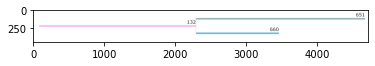

In [73]:
plt.imshow(family_im)

In [82]:
# create widget

def show_family(viewer: Viewer):
    
    active_label = viewer.layers['Labels'].selected_label
    
    family_im = my_napari.generate_family_image(df,labels_layer,active_label,graph_list[0])
    
    # remove previous graph
    h = viewer.window._dock_widgets['']
    viewer.window.remove_dock_widget(h)
    
    mpl_widget = FigureCanvas(Figure(tight_layout=True))

    ax = mpl_widget.figure.subplots(1)

    ax.imshow(family_im,extent=[0,220,0,50])
    ax.get_yaxis().set_visible(False)
    ax.tick_params(axis='x', colors='white')

    viewer.window.add_dock_widget(mpl_widget,area='bottom')

In [78]:
viewer.window._dock_widgets['']

In [83]:
# add family graph display button

family_button = magicgui(show_family, call_button='Show Family')
viewer.window.add_dock_widget(family_button,area='right')

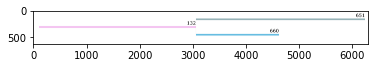

In [50]:
import matplotlib.pyplot as plt

plt.imshow(im)

In [34]:
graph

{299: 278, 300: 278, 651: 132, 660: 132, 677: 669, 678: 669}

In [ ]:
test = generate_family_image(df,current_track)